In [1]:
import numpy as np
import pandas as pd
import pickle
from itertools import compress
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns

%matplotlib inline

### Listings file contains characteristics of each listing
###               each row contains unique listing id
###
### Calendar file contains individual date availability going forward 
###               for a year for each listing
### 
### Reviews  file contains reviews up to the scrape date for some listings


listings_df = pd.read_csv('./listings_09_19.csv')
cols = ['host_response_rate','price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for col in cols:
    listings_df[col] = listings_df[col].astype(str).str.replace('%', '')
    listings_df[col] = listings_df[col].astype(str).str.replace('$', '')
    listings_df[col] = listings_df[col].astype(str).str.replace(',', '')
    listings_df[col] = listings_df[col].astype('float64')

## Use calendar prices here 
calendar_df = pd.read_csv('./calendar_09_19.csv')



In [2]:
### Here we are looking to predict prices based on available features. We have already shown the dependence
### on time of year , weekday vs. weekend, so we'll just average the prices over the year for each listing to simplify.
### So month and weekend categorical variables won't be part of the model.
##### Cleaning  calendar_df in this cell

calendar_df.date  = pd.to_datetime(calendar_df.date)
calendar_df.price = calendar_df.price.astype(str).str.replace('$','')
calendar_df.price = calendar_df.price.astype(str).str.replace(',','').astype('float64')

### Can show that only in about 1% of cases adjusted_price is different than price
### and I don't know how to interpret, so drop this
calendar_df.drop(['adjusted_price','available','minimum_nights','maximum_nights'],axis=1,inplace=True) 
calendar_df.listing_id.astype('int64',inplace = True) 
calendar_df.rename(columns={'listing_id': 'id'},inplace = True)
print(calendar_df.isnull().any())

calendar_df = calendar_df.groupby(['id'])['price'].agg(np.mean).to_frame().reset_index()
calendar_df.head()

id       False
date     False
price    False
dtype: bool


,id,price
0,2318,296.098630
1,5682,66.410959
2,6606,88.745205
3,9419,75.000000
4,9460,117.772603


In [3]:
listings_df.drop(['price'],axis=1,inplace=True)
listings_df = pd.merge(listings_df,calendar_df,  on='id', how='inner')

In [4]:
## Check if any NaNs on price
np.sum(listings_df.isnull()['price'])
listings_df.shape

(9040, 106)

In [5]:
### Remove absurdly small/large prices
listings_df = listings_df[listings_df.price > 8.0]
listings_df.price.describe()

count    9040.000000
mean      155.671987
std       144.399044
min        10.000000
25%        83.073288
50%       123.420548
75%       183.169178
max      5000.000000
Name: price, dtype: float64

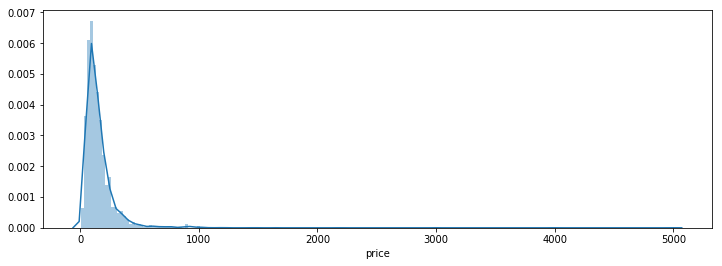

In [6]:
plt.figure(figsize=(12, 4))
sns.distplot(listings_df['price'], bins = 200)

In [7]:
### Restricting against large prices
listings_df = listings_df[ (listings_df.price < 3001.0)]
###np.sum(listings_df.isnull())

In [8]:
### Wrangle zipcodes
listings_df['zipcode'] = listings_df['zipcode'].map(lambda x:  str(x)[0:5])
listings_df = listings_df[listings_df['zipcode'].map(lambda x: len(x)==5)]

### Get numerical columns
num_cols = list(listings_df.select_dtypes(['float64','int64']).columns)

### Get categorical columns, restrict to using cat columns with less than 90 categories
cat_cols = list(listings_df.select_dtypes(['object']).columns)
cat_cols2 = cat_cols.copy()
for col in cat_cols:
    sz = len(listings_df[col].unique())
    if( (sz > 90) or (sz==1) ):
        cat_cols2.remove(col)
    

### Restrict to these columns, this throws out amenities
cols = num_cols + cat_cols2 + ['host_since']
listings_df = listings_df[cols]


### Remove columns here with too many NaNs
cols = list(listings_df.columns)
l    = list(np.mean(listings_df.isnull()) < 0.30)
listings_df = listings_df[list(compress(cols, l))]

### Remove other listing info that are not useful or I'm not sure how to interpret
listings_df.drop(['scrape_id','city','state', 'street', 'minimum_nights', 'maximum_nights',
                  'minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights',
                  'smart_location','market','jurisdiction_names','is_location_exact','latitude','longitude','host_since'],axis=1,inplace=True)
 
    
### Go ahead and prefer neighborhood_cleansed to neighborhood_group_cleansed here to improve fit
listings_df.drop(['neighbourhood_group_cleansed','neighbourhood'],axis=1,inplace=True)



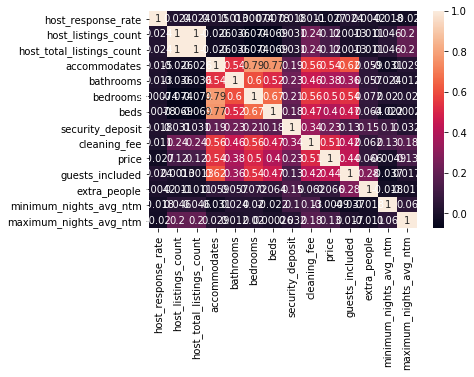

In [9]:
###  Price has Minimal correlation with 'accommodates',
### 'bathrooms',
### 'bedrooms',
### 'beds',
###'guests_included', cleaning fee,security_deposit

sns.heatmap(listings_df[['host_response_rate',
 'host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'security_deposit',
 'cleaning_fee',
 'price',
 'guests_included',
 'extra_people',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm']].corr(),annot=True)

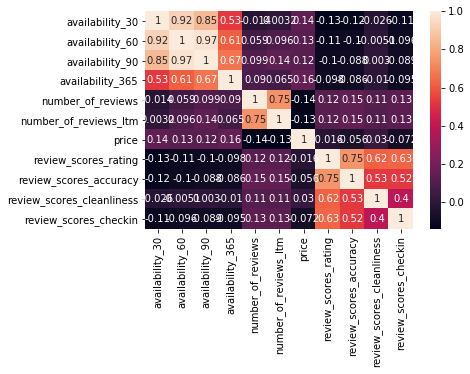

In [10]:
### Keep 'availability_30','availability_60',
sns.heatmap(listings_df[['availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'price',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin']].corr(),annot=True)
 

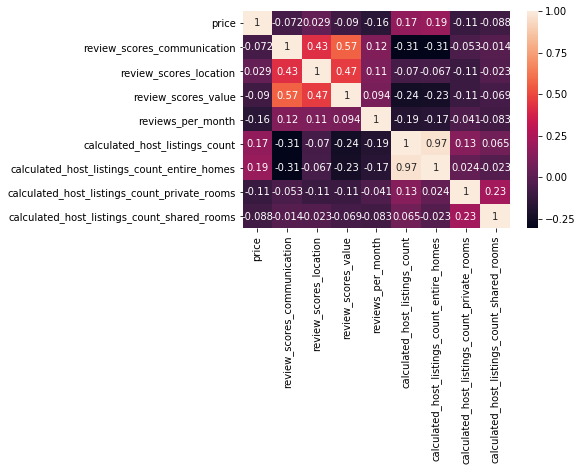

In [11]:
### Keep calculated_host_listings_count_entire_homes
sns.heatmap(listings_df[['price',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms']].corr(),annot=True)  

In [12]:
### So restrict numerical columns to 'accommodates', 'bathrooms', 'bedrooms','beds',
### 'guests_included', 'cleaning fee',security deposit
num_keep_cols = ['accommodates','bathrooms', 'bedrooms','beds','guests_included', 'cleaning_fee',
                 'security_deposit','price','availability_30','availability_60','calculated_host_listings_count_entire_homes']

## Categorical columns
cat_cols = list(listings_df.select_dtypes(['object']).columns)

### Restrict listings_df to these columns
cols = num_keep_cols + cat_cols
listings_df = listings_df[cols]

### Fill missing items in numerical columns with mean of column
for col in num_keep_cols:
    listings_df[col].fillna( listings_df[col].mean(), inplace = True)



In [13]:
### Count unique categories of each categorical column, number of rows for each needs to be large enough
### for a decent fit.
cat_cols = list(listings_df.select_dtypes(['object']).columns)

for col in cat_cols:
    uvals = listings_df[col].unique()
    for val in uvals:
        cnt = np.sum(listings_df[col]==val)
        print(col,"   ",val,"   ",cnt)
        


host_response_time     within an hour     6075
host_response_time     nan     0
host_response_time     within a few hours     738
host_response_time     within a day     280
host_response_time     a few days or more     31
host_is_superhost     t     3647
host_is_superhost     f     5218
host_is_superhost     nan     0
host_has_profile_pic     t     8858
host_has_profile_pic     f     7
host_has_profile_pic     nan     0
host_identity_verified     f     4015
host_identity_verified     t     4850
host_identity_verified     nan     0
neighbourhood_cleansed     Madrona     71
neighbourhood_cleansed     South Delridge     46
neighbourhood_cleansed     Wallingford     328
neighbourhood_cleansed     Georgetown     30
neighbourhood_cleansed     First Hill     345
neighbourhood_cleansed     Fairmount Park     45
neighbourhood_cleansed     Green Lake     134
neighbourhood_cleansed     Belltown     492
neighbourhood_cleansed     Adams     126
neighbourhood_cleansed     Broadway     547
neighbour

In [14]:
### From the above, eliminate some categorical values together, or eliminate others
### Drop zipcodes now in preference for neighborhoods
### Remove requires license,  host_has_profile_pic (most values are true), zipcode (prefer use of neighborhood)
listings_df.drop(columns = ['requires_license','host_has_profile_pic','zipcode','calendar_updated'],inplace = True)

In [15]:
### Check categorical columns again
cat_cols = list(listings_df.select_dtypes(['object']).columns)

# Loop columns
for col in cat_cols:
    uvals = listings_df[col].unique()
    for val in uvals:
        cnt = np.sum(listings_df[col]==val) ## NaN will give false here
        print(col,"   ",val,"   ",cnt)

host_response_time     within an hour     6075
host_response_time     nan     0
host_response_time     within a few hours     738
host_response_time     within a day     280
host_response_time     a few days or more     31
host_is_superhost     t     3647
host_is_superhost     f     5218
host_is_superhost     nan     0
host_identity_verified     f     4015
host_identity_verified     t     4850
host_identity_verified     nan     0
neighbourhood_cleansed     Madrona     71
neighbourhood_cleansed     South Delridge     46
neighbourhood_cleansed     Wallingford     328
neighbourhood_cleansed     Georgetown     30
neighbourhood_cleansed     First Hill     345
neighbourhood_cleansed     Fairmount Park     45
neighbourhood_cleansed     Green Lake     134
neighbourhood_cleansed     Belltown     492
neighbourhood_cleansed     Adams     126
neighbourhood_cleansed     Broadway     547
neighbourhood_cleansed     Whittier Heights     71
neighbourhood_cleansed     Eastlake     91
neighbourhood_clean

In [16]:
### Remove these property types since there is only one, or better map these to something else
b = (listings_df.property_type != 'Hostel') & (listings_df.property_type != 'Tent') \
& (listings_df.property_type != 'Villa') & (listings_df.property_type != 'Dome house') \
& (listings_df.property_type != 'Boutique hotel' ) & (listings_df.property_type != 'Yurt') \
& (listings_df.property_type != 'Camper/RV')

listings_df = listings_df[b]

#listings_df = listings_df.drop(['property_type'],axis=1)
np.sum(listings_df.isnull())
model_data_df = listings_df.dropna()
np.sum(model_data_df.isnull())
model_data_le_df = model_data_df.copy()
model_data_rf_df = model_data_df.copy()

In [17]:
### Multi-Linear Regression Fit
df = model_data_le_df.copy()
num_cols = list(listings_df.select_dtypes(['float64','int64']).columns)

### Standardize data
scaler       = StandardScaler().fit(df[num_cols].values)
df[num_cols] = scaler.transform(df[num_cols].values) 

cat_vars = df.select_dtypes(include=['object']).copy().columns
print(cat_vars)
for var in  cat_vars:
     df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)


y = df['price']
X = df.drop(['price'], axis=1)

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.25, random_state=9)

lm_model = LinearRegression(normalize=False)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

r2_train = r2_score(y_train, y_train_preds)
r2_test  = r2_score(y_test,  y_test_preds)

print("r2_train =  ",r2_train)
print("r2_test  =  ",r2_test)


coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
coefs_df = coefs_df.sort_values('coefs', ascending=False)

print(coefs_df.iloc[0:20])


Index(['host_response_time', 'host_is_superhost', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')
r2_train =   0.5263307824112909
r2_test  =   0.5556873303529128
                                              est_int     coefs  abs_coefs
107                              property_type_Castle  3.651289   3.651289
49      neighbourhood_cleansed_International District  2.037627   2.037627
113                               property_type_Hotel  1.574993   1.574993
134               cancellation_policy_super_strict_60  1.179146   1.179146
75              neighbourhood_cleansed_Pioneer Square  0.801371   0.801371
125                                    bed_type_Couch  0.796785   0.796785
97             neighbourhood_cleansed_West Queen Anne  0.550298   0.550298
99                    neighbourhood_

In [18]:
### Try Random Forest

df = model_data_rf_df

### Standardize data
scaler       = StandardScaler().fit(df[num_cols].values)
df[num_cols] = scaler.transform(df[num_cols].values) 


### Expand Categoricals to dummy variables
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
     df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=False)], axis=1)

y = df['price']
X = df.drop(['price'], axis=1)


# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.25, random_state=29)
rf_model = RandomForestRegressor(random_state = 42)
# Train the model on training data
rf_model.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Variable =  bedrooms   Importance =  0.23041338337560957
Variable =  accommodates   Importance =  0.09698701005324484
Variable =  cleaning_fee   Importance =  0.09582444350686042
Variable =  calculated_host_listings_count_entire_homes   Importance =  0.07893423355046383
Variable =  neighbourhood_cleansed_International District   Importance =  0.059301976153385325
Variable =  guests_included   Importance =  0.05861063434281982
Variable =  property_type_Guest suite   Importance =  0.04597315599501026
Variable =  security_deposit   Importance =  0.035005187669263166
Variable =  room_type_Private room   Importance =  0.028516722650966334
Variable =  bathrooms   Importance =  0.025250794546083644
Variable =  neighbourhood_cleansed_West Queen Anne   Importance =  0.023873351359750047
Variable =  availability_30   Importance =  0.023448673190262715
Variable =  availability_60   Importance =  0.02116490395645474
Variable =  host_response_time_a few days or more   Importance =  0.01659968272683

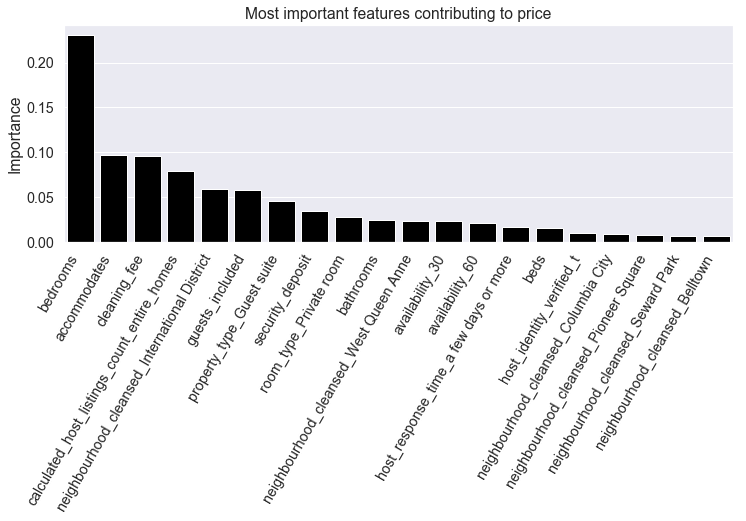

In [19]:
## List most significant variables
var_list        = list(X_train)
importance_list = list(rf_model.feature_importances_)

var_import = [list(x) for x in zip(*sorted(zip(var_list, importance_list),reverse=True, key=lambda pair: pair[1]))]

for i in range(0,30):
    print ("Variable = ",var_import[0][i],"  Importance = ",var_import[1][i])
    
var_list        = var_import[0][0:20]
importance_list = var_import[1][0:20]    
    
plt.figure(figsize=(12, 4))
sns.set(font_scale=1.3)
ax = sns.barplot(var_list,importance_list, color = 'black')    
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
ax.set_ylabel("Importance")
ax.set_title("Most important features contributing to price")


y_train_pred = rf_model.predict(X_train)
y_test_pred =  rf_model.predict(X_test)


print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))





In [20]:
IntDist_df = listings_df[listings_df.neighbourhood_cleansed == 'International District']
IntDist_df.head(20)

,accommodates,bathrooms,bedrooms,beds,guests_included,cleaning_fee,security_deposit,price,availability_30,availability_60,...,host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,bed_type,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
102,2,1.0,1.0,1.0,1,0.000000,250.000000,124.520548,15,45,...,t,t,International District,Loft,Private room,Real Bed,t,strict_14_with_grace_period,t,t
896,1,2.0,1.0,1.0,1,10.000000,0.000000,55.668493,27,57,...,t,t,International District,Other,Shared room,Real Bed,t,moderate,f,f
897,1,1.0,1.0,1.0,1,10.000000,252.851236,55.334247,30,60,...,t,t,International District,Other,Shared room,Real Bed,t,moderate,f,f
1622,2,1.0,1.0,1.0,1,76.074543,252.851236,130.000000,0,0,...,f,t,International District,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
1709,2,1.0,1.0,1.0,1,76.074543,252.851236,79.000000,0,0,...,f,f,International District,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
1811,2,1.0,0.0,2.0,1,25.000000,150.000000,65.000000,0,0,...,f,t,International District,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
1959,2,1.5,1.0,1.0,1,7.000000,95.000000,44.000000,0,0,...,f,f,International District,Apartment,Private room,Real Bed,f,moderate,f,f
2175,8,2.0,1.0,4.0,5,20.000000,200.000000,180.000000,0,0,...,f,t,International District,Apartment,Private room,Real Bed,t,moderate,f,f
2363,1,1.0,1.0,1.0,1,10.000000,252.851236,55.049315,30,60,...,t,t,International District,Other,Shared room,Real Bed,t,moderate,f,f
2497,4,1.0,1.0,2.0,1,76.074543,252.851236,130.000000,0,0,...,f,f,International District,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
